### Check GPU Availability

In [1]:
!nvidia-smi

Fri Apr  4 03:41:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Installation

In [2]:
%%capture
# Temporarily as of Jan 31st 2025, Colab has some issues with Pytorch
# Using pip install unsloth will take 3 minutes, whilst the below takes <1 minute:
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29 peft trl triton==3.1.0
!pip install --no-deps cut_cross_entropy
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install unsloth==2025.2.15 unsloth_zoo==2025.2.7
!pip install transformers==4.49.0

In [3]:
!git clone https://github.com/ericsunkuan/ML_Spring2025_HW5.git

Cloning into 'ML_Spring2025_HW5'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 27 (delta 10), reused 21 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (27/27), 12.73 MiB | 20.31 MiB/s, done.
Resolving deltas: 100% (10/10), done.


### Unsloth

#### Note : Changing the model is against the Rules of Homework 5 !!!

### Initialize the LLM

In [4]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

### Changing the model here is forbidden !

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-2-7b-bnb-4bit",    ### Do not change the model for any other models or quantization versions
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.2.15: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    GPU: Tesla T4. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/3.87G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/183 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/948 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

Add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [5]:
################# TODO : Tweak the LoRA adapter hyperparameters here.  #####################

model = FastLanguageModel.get_peft_model(
    model,
    r = 128, ### TODO : Choose any number > 0 ! Common values are 4, 8, 16, 32, 64, 128. Higher ranks allow more expressive power but also increase parameter count.
    lora_alpha = 128,  ### TODO : Choose any number > 0 ! Suggested 4, 8, 16, 32, 64, 128
    lora_dropout = 0.05, # Supports any, but = 0 is optimized


################# TODO  ####################################################################
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.2.15 patched 32 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


In [6]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",  ### Use llama-3.1 template for better performance here
)

def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }
pass


# Dataset Preperation (Loading and Refining)

## Data Filtering & Sorting

In [7]:
from datasets import load_dataset, Dataset, load_from_disk

# Load the dataset from Hugging Face
dataset = load_from_disk("ML_Spring2025_HW5/fastchat_alpaca_52k")

# # ---------------------------
# # Add a "text" field to each example
# # ---------------------------
# # This function extracts the first assistant message from the conversation
# def add_text_field(example):
#     # Extract the first message where role == 'assistant'
#     assistant_texts = [msg["content"] for msg in example["conversations"] if msg["role"] == "assistant"]
#     text = assistant_texts[0] if assistant_texts else ""
#     return {"text": text}

# # Map the function over the dataset to add the "text" column.
# dataset = dataset.map(add_text_field)

# Print the dataset structure to confirm the new feature.
print(dataset)


# ---------------------------
#################### TODO : Define a helper function for computing conversation length ###############

# The default "conversation length" here refers to the length of the input (human) and output (gpt), you can modify it at your will

def compute_conversation_length(example):
    # Compute total word count across all messages in the 'conversations' field
    # return sum(len(message["content"].split()) for message in example["conversations"])
    # Compute total word count across all messages in the 'output' field
    return sum(len(message["content"].split()) for message in example["conversations"] if message["role"] == "assistant")


#################### TODO ############################################################################

# ---------------------------
# Simple Sorting Method  (Default)
# ---------------------------
# Sort the dataset from longest to shortest conversation (by word count)
sorted_dataset_simple_list = sorted(dataset, key=compute_conversation_length, reverse=True)

# Convert back to a Dataset object
sorted_dataset_simple = Dataset.from_list(sorted_dataset_simple_list)

print("\nTop examples sorted by simple assistant conversation length (Longest first):")
for entry in sorted_dataset_simple.select(range(10)):
    print(f"ID: {entry['id']}, Assistant Conversation Length: {compute_conversation_length(entry)}")
# ---------------------------



############## Advanced Sorting Method (TODO : Modify the sorting key ##################
# ---------------------------
# Default : Sorting based on Combining conversation length with the 'score' field using a weighted sum.
# Here, we multiply the score by 10 and add it to the conversation length.
def advanced_sort_key(example):
    assistant_conversation_len = compute_conversation_length(example)
    score = example["score"]
    if score >= 5:
        return assistant_conversation_len + score * 100
    return assistant_conversation_len

####################################### TODO ###########################################

sorted_dataset_advanced_list = sorted(dataset, key=advanced_sort_key, reverse=True)
# Convert back to a Dataset object
sorted_dataset_advanced = Dataset.from_list(sorted_dataset_advanced_list)

print("\nTop examples sorted by advanced key (combination of assistant conversation length and score, Longest first):")
for entry in sorted_dataset_advanced.select(range(10)):
    print(f"ID: {entry['id']}, Advanced Key Value: {advanced_sort_key(entry)}")


Dataset({
    features: ['id', 'conversations', 'score'],
    num_rows: 52002
})

Top examples sorted by simple assistant conversation length (Longest first):
ID: identity_45289, Assistant Conversation Length: 717
ID: identity_6285, Assistant Conversation Length: 625
ID: identity_15102, Assistant Conversation Length: 597
ID: identity_18853, Assistant Conversation Length: 544
ID: identity_15908, Assistant Conversation Length: 525
ID: identity_18295, Assistant Conversation Length: 513
ID: identity_39031, Assistant Conversation Length: 499
ID: identity_26999, Assistant Conversation Length: 491
ID: identity_13930, Assistant Conversation Length: 486
ID: identity_25650, Assistant Conversation Length: 479

Top examples sorted by advanced key (combination of assistant conversation length and score, Longest first):
ID: identity_45289, Advanced Key Value: 717
ID: identity_6285, Advanced Key Value: 625
ID: identity_15102, Advanced Key Value: 597
ID: identity_18853, Advanced Key Value: 544
ID: ide

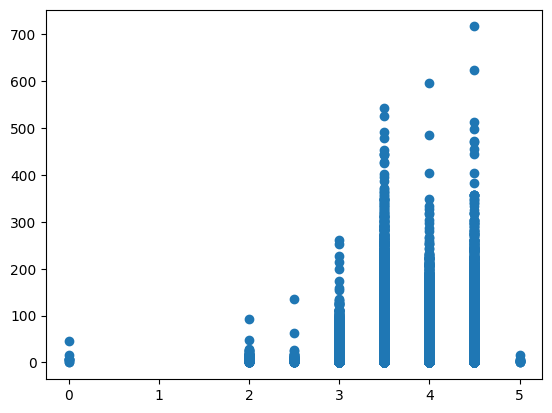

In [8]:
import matplotlib.pyplot as plt

x = [data["score"] for data in dataset]
y = [compute_conversation_length(data) for data in dataset]

plt.scatter(x,y)
plt.show()

#### Note : You are limited to use 100 sorted data among the 1000 data in the given dataset, no more than 100 data is allowed for training !!!

In [9]:
################# TODO : select the simple or advanced dataset for training ##############

dataset_used = "sorted_dataset_advanced" # sorted_dataset_simple

################# TODO ###################################################################

if dataset_used == "sorted_dataset_simple":
    sorted_dataset = sorted_dataset_simple
else:
    sorted_dataset = sorted_dataset_simple

train_dataset = sorted_dataset.select(range(0,100))    ### You can also select from the middle, e.g. sorted_dataset_simple.select(range(50,150))

from unsloth.chat_templates import standardize_sharegpt
train_dataset = standardize_sharegpt(train_dataset)
train_dataset = train_dataset.map(formatting_prompts_func, batched = True,)

# valid unsloth 有問題
# https://github.com/unslothai/unsloth/issues/1921
# 但弄成新版，又有其他問題 https://github.com/unslothai/unsloth/issues/2199
# split_dataset = train_dataset.train_test_split(test_size=0.1, seed=3407) # 抽取 10% (10筆) 作為驗證集
# train_dataset = split_dataset["train"]
# eval_dataset = split_dataset["test"]
# print(f"訓練集大小: {len(train_dataset)}")
# print(f"驗證集大小: {len(eval_dataset)}")

Standardizing format:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

# Dataset Visualize

In [10]:
print(sorted_dataset[5]["conversations"])

[{'content': 'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. ### Instruction: Generate a list of ideas for activities for a business meeting. ### Input: No input.', 'role': 'user'}, {'content': 'Here are some ideas for activities for a business meeting:\n\n1. Think Tank – In this activity, the team works together to come up with creative solutions to a specific problem.\n\n2. Problem Solving – Give each small group a different problem and have them work on it for a certain amount of time. Afterwards, have each group present their findings to the rest of the team.\n\n3. Mini-presentations – Have each team member prepare a mini-presentation on a topic that they are passionate about, whether it’s related to their job or something personal.\n\n4. Lucky Draw – Pick names out of a hat, and assign each person to give a short presentation on a surprise topic.\n\n5. Brainstorming Sessi

And we see how the chat template transformed these conversations.

**[Notice]** Llama 3.1 Instruct's default chat template default adds `"Cutting Knowledge Date: December 2023\nToday Date: 26 July 2024"`, so do not be alarmed!

In [11]:
print(train_dataset[5]["text"])
# print("=========================")
# print(eval_dataset[0]["text"])

<s><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. ### Instruction: Generate a list of ideas for activities for a business meeting. ### Input: No input.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Here are some ideas for activities for a business meeting:

1. Think Tank – In this activity, the team works together to come up with creative solutions to a specific problem.

2. Problem Solving – Give each small group a different problem and have them work on it for a certain amount of time. Afterwards, have each group present their findings to the rest of the team.

3. Mini-presentations – Have each team member prepare a mini-presentation on a topic that they are passionate about, whether it’s related to their jo

In [12]:
print("--- 檢查 train_dataset ---")
for i, example in enumerate(train_dataset):
    print(f"樣本 {i}:")
    try:
        inputs = tokenizer(example['text'], return_tensors="pt", truncation=True, max_length=max_seq_length)
        print(f"  Tokenized Length: {len(inputs['input_ids'][0])}")
        if len(inputs['input_ids'][0]) == 0:
            print(f"  ‼️ 警告: Tokenize 後長度為 0!")
    except Exception as e:
        print(f"  ‼️ 錯誤: Tokenize 時出錯: {e}")
    print("-" * 10)
print("--- 檢查結束 ---")

--- 檢查 train_dataset ---
樣本 0:
  Tokenized Length: 1198
----------
樣本 1:
  Tokenized Length: 1406
----------
樣本 2:
  Tokenized Length: 977
----------
樣本 3:
  Tokenized Length: 900
----------
樣本 4:
  Tokenized Length: 935
----------
樣本 5:
  Tokenized Length: 871
----------
樣本 6:
  Tokenized Length: 813
----------
樣本 7:
  Tokenized Length: 823
----------
樣本 8:
  Tokenized Length: 983
----------
樣本 9:
  Tokenized Length: 750
----------
樣本 10:
  Tokenized Length: 851
----------
樣本 11:
  Tokenized Length: 882
----------
樣本 12:
  Tokenized Length: 831
----------
樣本 13:
  Tokenized Length: 747
----------
樣本 14:
  Tokenized Length: 788
----------
樣本 15:
  Tokenized Length: 803
----------
樣本 16:
  Tokenized Length: 715
----------
樣本 17:
  Tokenized Length: 703
----------
樣本 18:
  Tokenized Length: 738
----------
樣本 19:
  Tokenized Length: 717
----------
樣本 20:
  Tokenized Length: 975
----------
樣本 21:
  Tokenized Length: 905
----------
樣本 22:
  Tokenized Length: 716
----------
樣本 23:
  Tokenize

## Training

In [13]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported


################# TODO : Tweak the training hyperparameters here.  #####################


training_config = {
    "per_device_train_batch_size": 4,
    "gradient_accumulation_steps": 2,
    "warmup_steps": 10,
    "num_train_epochs": 5,
    "learning_rate": 3e-5,
    "optim": "adamw_8bit",
    "weight_decay": 0.01,
    "lr_scheduler_type": "linear",
    "seed": 3407,   ### Do not modify the seed for reproducibility
}


################# TODO #################################################################

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    dataset_text_field = "text",
    # eval_dataset = eval_dataset,   # <--- 加入驗證集
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = training_config["per_device_train_batch_size"],
        gradient_accumulation_steps = training_config["gradient_accumulation_steps"],
        warmup_steps = training_config["warmup_steps"],
        num_train_epochs = training_config["num_train_epochs"], # Set this for 1 full training run.
        # max_steps = 60,
        learning_rate = training_config["learning_rate"],
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = training_config["optim"],
        weight_decay = training_config["weight_decay"],
        lr_scheduler_type = training_config["lr_scheduler_type"],
        seed = training_config["seed"],
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc

        # # --- 加入以下驗證參數 ---
        # evaluation_strategy = "steps",       # 每 N 步驗證一次
        # eval_steps = 1,                     # 例如每 1 步驗證一次 (因為總步數很少)
        # save_strategy = "steps",            # 同步儲存策略
        # save_steps = 5,                     # 同步儲存頻率
        # load_best_model_at_end = True,      # 訓練結束時載入最佳模型
        # metric_for_best_model = "eval_loss",# 以驗證損失作為標準
        # greater_is_better = False,          # 損失越小越好
        # save_total_limit = 2,               # 最多儲存幾個檢查點
    ),
)

Converting train dataset to ChatML (num_proc=2):   0%|          | 0/100 [00:00<?, ? examples/s]

Applying chat template to train dataset (num_proc=2):   0%|          | 0/100 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=2):   0%|          | 0/100 [00:00<?, ? examples/s]

Truncating train dataset (num_proc=2):   0%|          | 0/100 [00:00<?, ? examples/s]

We also use Unsloth's `train_on_completions` method to only train on the assistant outputs and ignore the loss on the user's inputs.

In [14]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
    response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",
)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [15]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 100 | Num Epochs = 5
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 2
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 319,815,680


Step,Training Loss
1,1.068300
2,1.224900
3,1.419700
4,1.010300
5,1.148600
6,1.299600
7,1.363600
8,1.266600
9,1.154900
10,1.122700


#### TODO : Curriculum Training  (Optional)
start training the LLM with “easier” examples (e.g., shorter, clearer conversations) and progressively introduce more complex ones.

The total data amount used to train should still not exceed 100 data.

In [16]:
############## TODO : Curriculum Training  ######################

### E.g.
### Step 1. Train on sorted_dataset_simple
### Step 2. Train on sorted_dataset_advanced

<a name="Inference"></a>
## Inference


In [17]:
def parse_true_output(text):
    """
    Extracts the true assistant output from the decoded model output.

    It looks for the assistant header token:
        "<|start_header_id|>assistant<|end_header_id|>\n\n"
    and extracts everything after it until the first occurrence of "<|eot_id|>".
    If the assistant header is not found, it falls back to the last occurrence
    of "<|end_header_id|>\n\n". If "<|eot_id|>" is not found, the extraction
    continues until the end of the string.
    """
    assistant_header = "<|start_header_id|>assistant<|end_header_id|>\n\n"
    start_index = text.find(assistant_header)
    if start_index != -1:
        start_index += len(assistant_header)
    else:
        # Fallback: use the last occurrence of the generic header ending
        generic_header = "<|end_header_id|>\n\n"
        start_index = text.rfind(generic_header)
        if start_index != -1:
            start_index += len(generic_header)
        else:
            start_index = 0

    end_index = text.find("<|eot_id|>", start_index)
    if end_index == -1:
        end_index = len(text)
    return text[start_index:end_index].strip()

In [18]:
from unsloth.chat_templates import get_chat_template
import json
from datetime import datetime

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

# Load the test set JSON file (without GPT responses)
with open("ML_Spring2025_HW5/test_set_evol_instruct_150.json", "r") as infile:
    test_data = json.load(infile)

# Dictionary to store inference results
inference_results = {}

# Loop over each data entry in the test set
for index,entry in enumerate(test_data):
    entry_id = entry.get("id", "unknown_id")

    # Build the messages list from the human conversation entries
    # (Test set is expected to have only "human" messages)
    messages = []
    for conv in entry.get("conversations", []):
        if conv.get("from") == "human":
            messages.append({"role": "user", "content": conv.get("value", "")})
        else:
            messages.append({"role": "assistant", "content": conv.get("value", "")})

    # Create inputs using the chat template (required for generation)
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,  # Must add for generation
        return_tensors="pt",
    ).to("cuda")


################# TODO : Tweak Decoding Parameters here.  #####################


    # Generate model outputs
    outputs = model.generate(
        input_ids=inputs,
        do_sample=True,
        max_new_tokens=1024,
        use_cache=True,
        temperature=0.6,
        top_p = 0.9,
        top_k = 50,
    )


################# TODO  ##########################################################

    # Decode the generated tokens
    decoded_outputs = tokenizer.batch_decode(outputs)

    # Parse each output to extract the true assistant response
    parsed_outputs = [parse_true_output(output) for output in decoded_outputs]

    # Store the result for the current entry
    inference_results[entry_id] = {
        "input": messages,
        "output": parsed_outputs
    }

    print(f"Inference completed for entry {entry_id}")
    if index < 10:
        print()
        print("===============================================")
        question = messages[0]["content"].replace("Below is an instruction that describes a task. Write a response that appropriately completes the request. ### Instruction:", "")
        print(f"Q: {question}")
        print(f"A: {parsed_outputs[0]}")
        print()
        print("===============================================")
        print()


#Write the inference results to the prediction JSON file
with open(f"pred.json", "w") as outfile:
    json.dump(inference_results, outfile, indent=4)
with open(f"training_config.json", "w") as outfile:
    json.dump(training_config, outfile, indent=4)

from google.colab import files
files.download('pred.json')

print("Inference completed for all entries in the test set.")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Inference completed for entry identity_8174

Q:  Reorganize the words and punctuation marks to make a correct sentence.
dog the brown my is
A: My dog, the brown one, is the best.
</s>


Inference completed for entry identity_16675

Q:  Translate the phrase, "le roi est mort" into English.
A: The king is dead.

The phrase "le roi est mort" is a French expression that translates to "the king is dead" in English. This expression is often used to express the death of a monarch or the end of an era.

The phrase originated in the Middle Ages, when it was used to announce the death of a king. It is still used today, often in a figurative sense to refer to the end of a period of time or the death of an era.

In modern times, the phrase is often used to express the death of a powerful person or the end of an era. For example, it is often used to announce the death of a beloved leader, such as a president or a prime minister. It is also used to announce the death of an era, such as the end of an

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Inference completed for all entries in the test set.


## Saving, loading finetuned models

### Save the model

In [19]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.model',
 'lora_model/added_tokens.json',
 'lora_model/tokenizer.json')

### Load the model

In [20]:
%%script false --no-raise-error

from unsloth import FastLanguageModel
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "lora_model", # The folder path containing of the folder that contains adapter_model.safetensors, adapter_config.json and README.md
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference